In [ ]:
from __future__ import annotations

import csv
import re
from pathlib import Path
from typing import Dict, Any

import pandas as pd
import stanza
from tqdm.auto import tqdm

try:
    from wordfreq import zipf_frequency  # for rare-word ratio
except ImportError:                      # make it optional
    zipf_frequency = lambda w, lang: 5.0  # ≈ neutral frequency

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
!pip install -q stanza
!pip install -q wordfreq
!pip install -q seaborn matplotlib

import pandas as pd
import stanza
stanza.download("en")
import re
from typing import Dict, List, Any, Optional
from pathlib import Path
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from wordfreq import zipf_frequency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 850.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [3]:
import logging
from typing import Dict, Any

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
bulwer.tsv
                                    tree_depth           dep_distance  \
                                          mean       std         mean   
genre                                                                   
Adventure                             5.000000  2.138090     3.154806   
Children's & Young Adult Literature   2.000000       NaN     1.333333   
Children's Literature                 9.000000  8.485281     3.168831   
Children’s Literature                 9.000000       NaN     3.333333   
Crime & Detective                     5.800000  2.489980     3.180035   
Dark & Stormy                         5.000000  1.414214     3.177350   
Dark and Stormy Night                 9.000000       NaN     4.371795   
Detective                             6.333333  2.081666     3.462597   
Fantasy                               6.750000  2.872281 

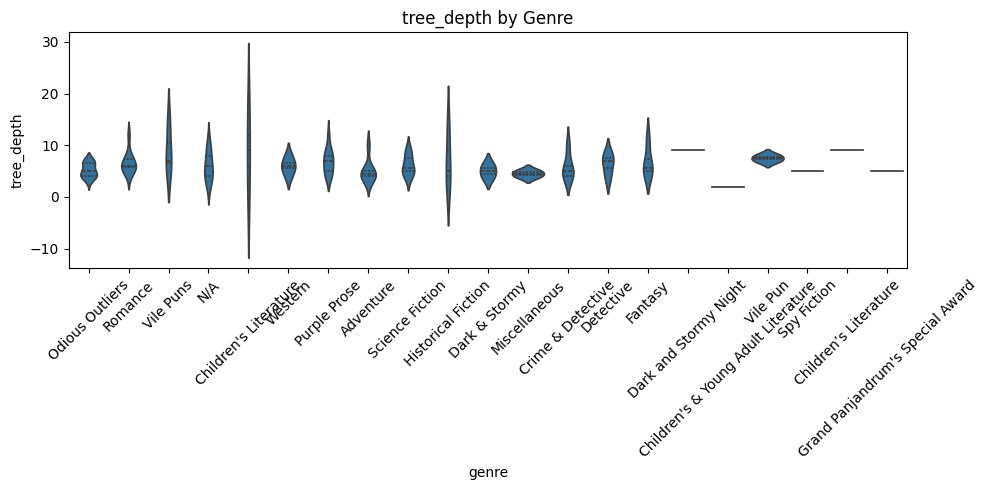

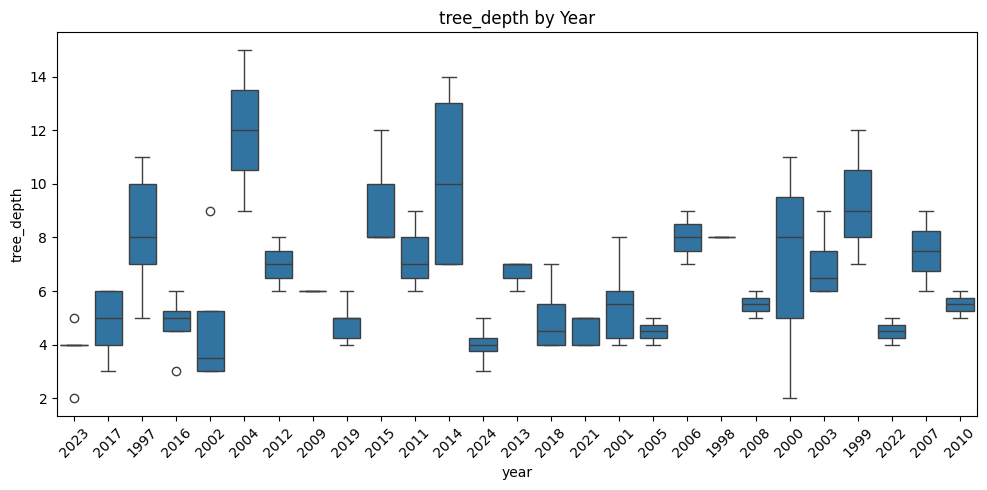

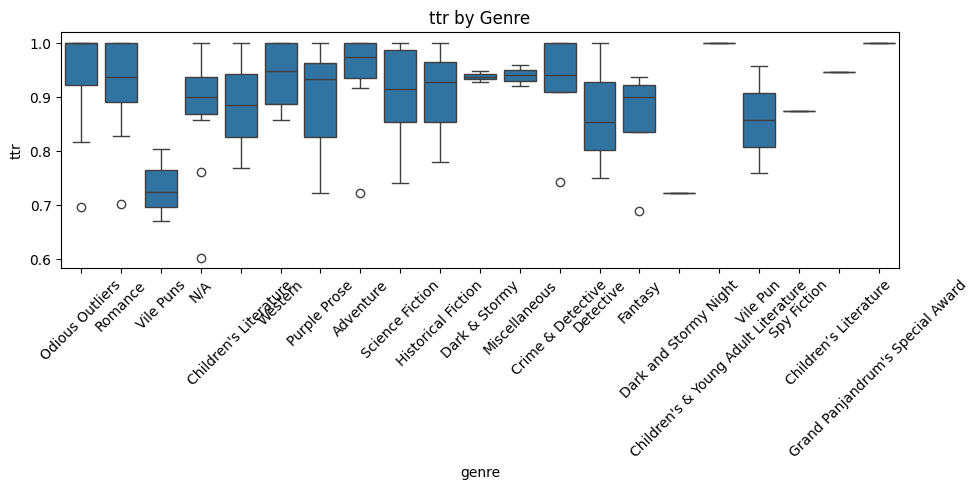

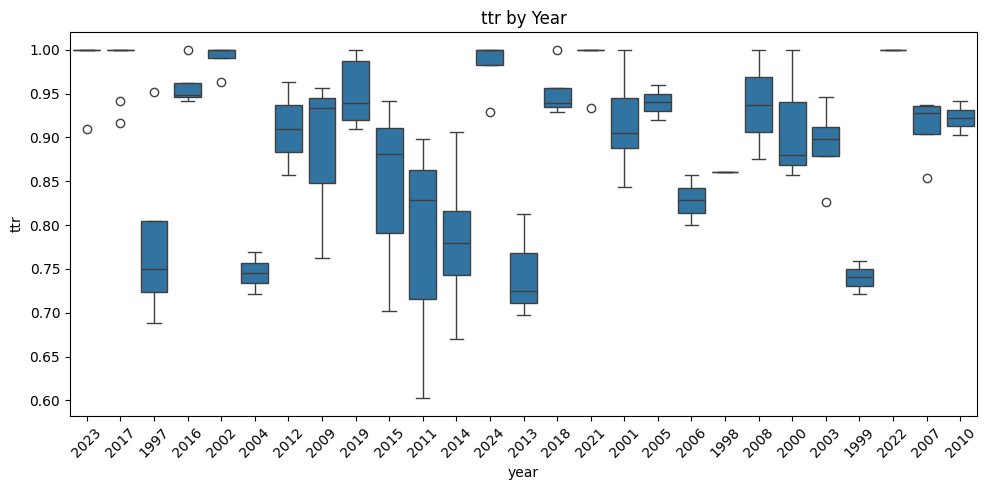

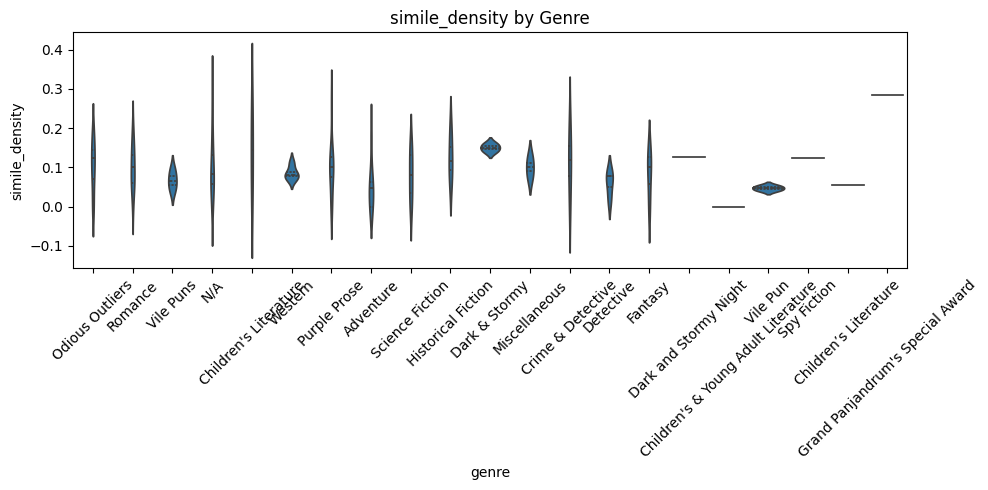

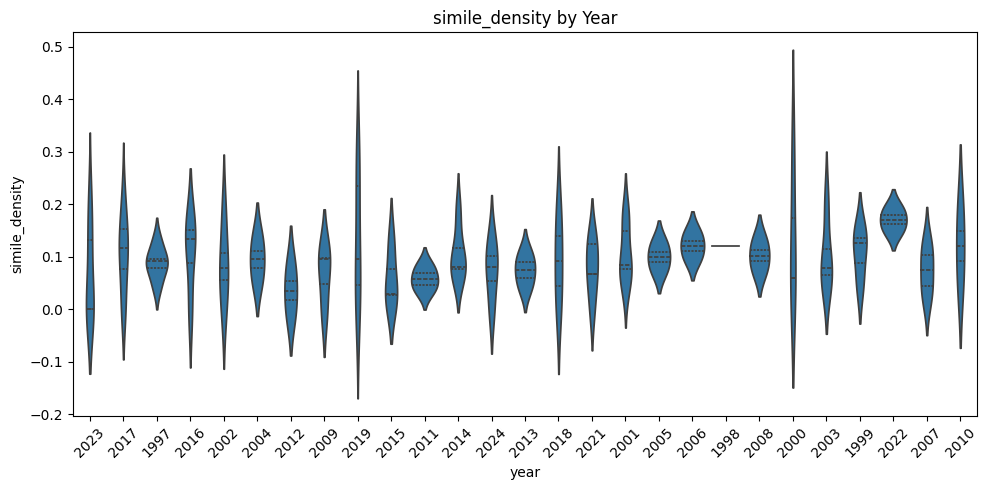

In [4]:
class BulwerLyttonAnalyzer:
    """Encapsulates all analysis logic in a reusable class"""

    def __init__(self, data_path: str | Path, *, gpu: bool = False):
        self.df: pd.DataFrame = self.load_data(data_path)
        self.nlp = self._init_nlp(gpu=gpu)
        self._simile_re = re.compile(r"\b(?:like|as)\b", flags=re.I)

    # 1. read
    def load_data(self, filepath: str) -> pd.DataFrame:
      # Load and clean TSV data
      df = pd.read_csv(filepath,
                       sep="\t",
                       quoting=csv.QUOTE_NONE,
                       on_bad_lines="skip",
                       keep_default_na=False
                       )
      expected = ["year", "text", "genre", "author", "location", "winning"]
      df.columns = expected[: len(df.columns)]
      df["genre"] = df["genre"].fillna("General")
      df["text"] = df["text"].astype(str)
      return df

    # 2. pipline
    def _init_nlp(self, *, gpu: bool = False) -> stanza.Pipeline:
      # Initialize Stanza
      return stanza.Pipeline(
            lang="en",
            processors="tokenize,pos,lemma,depparse,ner",
            use_gpu=gpu,
            tokenize_pretokenized=False,
            verbose=False,
            download_method=None
        )

    # 3. Feature
    # syntax
    @staticmethod
    def _tree_depth(sentence: stanza.models.common.doc.Sentence) -> int:
        """Return max depth from any node to ROOT (inclusive)."""
        # build parent dict once:
        parents = {word.id: word.head for word in sentence.words}
        max_depth = 0
        for wid in parents:
            d = 0
            while wid != 0:
                wid = parents[wid]
                d += 1
            max_depth = max(max_depth, d)
        return max_depth

    @staticmethod
    def _dependency_distance(sentence: stanza.models.common.doc.Sentence) -> float:
        """Mean absolute distance head<->dep."""
        dists = [abs(w.id - w.head) for w in sentence.words if w.head != 0]
        return sum(dists) / len(dists) if dists else 0.0

    _FEATURE_KEYS = [
        # syntactic
        "tree_depth", "dep_distance", "clause_ratio",
        "conj_count", "avg_sent_len",
        # lexical
        "ttr", "rare_ratio", "ner_density", "pos_diversity",
        # rhetoric
        "simile_density", "adj_count"
    ]

    def _zero_feat(self) -> Dict[str, float]:
        """dict with feature 0"""
        return {k: 0.0 for k in self._FEATURE_KEYS}

    def _extract_features(self, row: pd.Series) -> Dict[str, Any]:
        """Main feature extraction router"""
        text = str(row.get("text", "")).strip()
        if not text:
            return self._zero_feat()
        try:
            doc: stanza.Document = self.nlp(text)
        except Exception as e:
            logging.warning(
                "Stanza failed on row %s (%s) — %s",
                row.name, text[:40] + ("…" if len(text) > 40 else ""), e
            )
            return self._zero_feat()

        # Flatten tokens
        tokens = [w.text for s in doc.sentences for w in s.words]
        n_tokens = len(tokens)
        if n_tokens == 0:
            return self._zero_feat()

        feats = {}
        feats.update(self._extract_syntax_features(doc, n_tokens))
        feats.update(self._extract_lexical_features(doc, tokens))
        feats.update(self._extract_rhetoric_features(text, doc, n_tokens))
        return feats

    def _extract_syntax_features(self, doc: stanza.Document, n_tokens: int) -> Dict[str, float]:
        """Calculate syntactic complexity metrics"""
        if not doc.sentences:
            return {
                "tree_depth": 0.0,
                "dep_distance": 0.0,
                "clause_ratio": 0.0,
                "conj_count": 0.0,
                "avg_sent_len": 0.0
            }

        # Sentence-level metrics
        depths = []
        dep_dists = []
        sent_lengths = []
        n_clauses = 0
        n_conj = 0
        n_deprel = 0

        for sent in doc.sentences:
            depths.append(self._tree_depth(sent))
            dep_dists.append(self._dependency_distance(sent))
            sent_lengths.append(len(sent.words))

            for word in sent.words:
                if word.deprel in {"acl", "advcl", "relcl"}:
                    n_clauses += 1
                elif word.deprel == "conj":
                    n_conj += 1

            n_deprel += len(sent.words)

        return {
            "tree_depth": max(depths),
            "dep_distance": sum(dep_dists) / len(dep_dists),
            "clause_ratio": n_clauses / n_deprel if n_deprel else 0.0,
            "conj_count": n_conj,
            "avg_sent_len": sum(sent_lengths) / len(sent_lengths)
        }

    def _extract_lexical_features(self, doc: stanza.Document, tokens: List[str]) -> Dict[str, float]:
        """Calculate lexical creativity metrics"""
        if not tokens:
            return {
                "ttr": 0.0,
                "rare_ratio": 0.0,
                "ner_density": 0.0,
                "pos_diversity": 0.0
            }

        # Unique words
        unique_tokens = set(tokens)

        # Rare words (Zipf frequency < 3)
        rare_words = sum(1 for w in tokens if zipf_frequency(w, "en") < 3.0)

        # POS diversity
        pos_tags = [w.upos for s in doc.sentences for w in s.words]

        # NER density
        n_ents = len(doc.ents)

        return {
            "ttr": len(unique_tokens) / len(tokens),
            "rare_ratio": rare_words / len(tokens),
            "ner_density": n_ents / len(tokens),
            "pos_diversity": len(set(pos_tags)) / len(pos_tags) if pos_tags else 0.0
        }

    def _extract_rhetoric_features(self, text: str, doc: stanza.Document, n_tokens: int) -> Dict[str, float]:
        """Detect rhetorical devices"""
        if not doc.sentences:
            return {
                "simile_density": 0.0,
                "adj_count": 0.0
            }

        # Adjectives
        n_adj = sum(1 for w in doc.iter_words() if w.xpos and w.xpos.startswith("JJ"))

        # Similes
        n_like_as = len(self._simile_re.findall(text.lower()))

        return {
            "simile_density": (n_adj + n_like_as) / n_tokens if n_tokens else 0.0,
            "adj_count": n_adj
        }

    # 4. Analysis Methods
    # ----------------------------
    def analyze(self, sample_size: Optional[int] = None) -> None:
        """Run full analysis pipeline"""
        if sample_size is None:
          self.df = self.df.reset_index(drop=True)
        else:
          n = min(sample_size, len(self.df))
          self.df = (self.df.sample(n, random_state=42)
                         .reset_index(drop=True))

        # Apply feature extraction
        feature_dicts = self.df.apply(self._extract_features, axis=1).tolist()
        features_df   = pd.DataFrame(feature_dicts)

        dup_cols = [c for c in features_df.columns if c in self.df.columns]
        self.df.drop(columns=dup_cols, inplace=True, errors="ignore")
        self.df = pd.concat([self.df, features_df], axis=1)
        self.df = self.df.loc[:, ~self.df.columns.duplicated()].copy()

    def genre_summary(self) -> pd.DataFrame:
        """Statistical summary by genre"""
        num_cols = self.df.select_dtypes(include=['number']).columns
        return self.df.groupby("genre")[num_cols].agg(["mean", "std"])

    def year_summary(self, stats: tuple[str, ...] = ("mean", "std", "count")
                     ) -> pd.DataFrame:
        """Descriptive statistics for every numeric feature **per year**."""
        num_cols = self.df.select_dtypes(include="number").columns
        return self.df.groupby("year")[num_cols].agg(stats)

    def plot_feature(self, feature: str, *, kind: str = "violin",
                     by: str = "genre", order: Optional[List[str]] = None) -> None:
        """Visualize feature distribution by genre or year"""
        x_col = by if by in {"genre", "year"} else "genre"
        if x_col == "year":
            self.df["year_str"] = self.df["year"].astype(str)

        plt.figure(figsize=(10, 5))
        if kind == "box":
            sns.boxplot(data=self.df, x=x_col, y=feature, order=order)
        elif kind == "swarm":
            sns.swarmplot(data=self.df, x=x_col, y=feature, order=order, size=3)
        else:
            sns.violinplot(data=self.df, x=x_col, y=feature, order=order,
                           inner="quartile")
        plt.title(f"{feature} by {x_col.capitalize()}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

from google.colab import drive
drive.mount('/content/drive')

if __name__ == "__main__":

    !ls -R /content/drive/MyDrive | grep bulwer
    file_path = "/content/drive/MyDrive/bulwer.tsv"
    analyzer = BulwerLyttonAnalyzer(file_path, gpu=True)

    # Analyze first 100 entries
    analyzer.analyze(sample_size=100)

    # Show summary
    print(analyzer.genre_summary())
    year_stats = analyzer.year_summary()
    print(year_stats)
    year_stats.to_csv("/content/drive/MyDrive/bulwer_year_summary.csv")

    # Visualize key features
    analyzer.plot_feature("tree_depth")
    analyzer.plot_feature("tree_depth", by="year", kind="box")
    analyzer.plot_feature("ttr", kind="box")
    analyzer.plot_feature("ttr", kind="box",  by="year")
    analyzer.plot_feature("simile_density")
    analyzer.plot_feature("simile_density", by="year")


Mounted at /content/drive
bulwer.tsv
bulwer_year_summary.csv
Kruskal-Wallis H=47.19, p=3.62e-07
                   tree_depth           dep_distance           clause_ratio  \
                         mean       std         mean       std         mean   
genre                                                                         
Adventure            6.302083  2.157580     3.609339  0.800895     0.030160   
Crime & Detective    5.805195  2.121562     3.439498  0.801926     0.027267   
Historical Fiction   5.826087  2.079002     3.622849  0.788684     0.028896   
N/A                  7.063830  2.588781     3.818254  0.707535     0.029307   
Odious Outliers      5.810000  2.213231     3.372951  0.786787     0.025605   
Purple Prose         6.516484  2.493584     3.472269  0.700403     0.033161   
Romance              6.589928  2.196219     3.599564  0.765002     0.031280   
Science Fiction      5.886598  2.159650     3.423432  0.813088     0.020589   
Vile Puns            6.061404  2.38

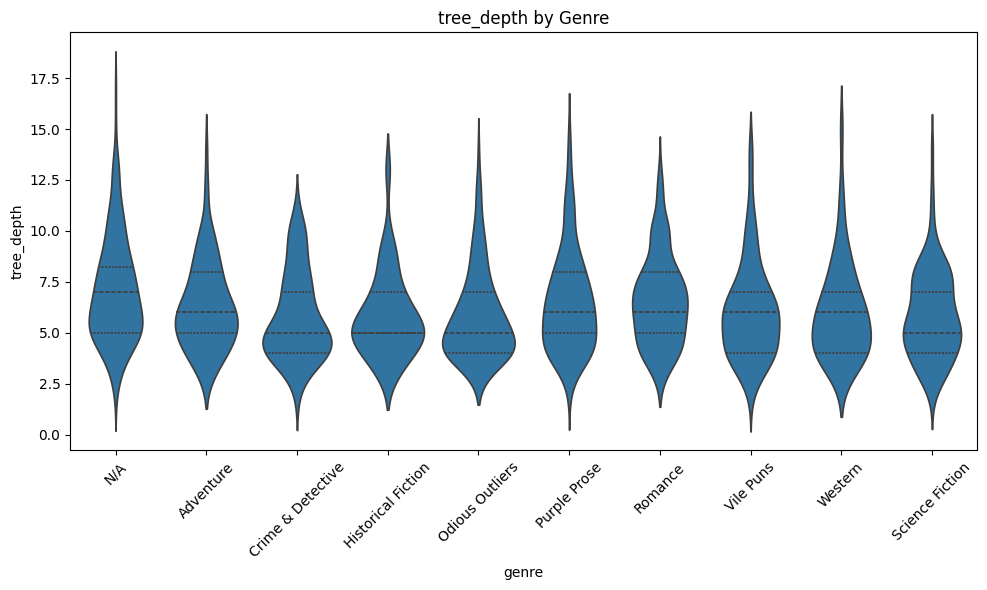

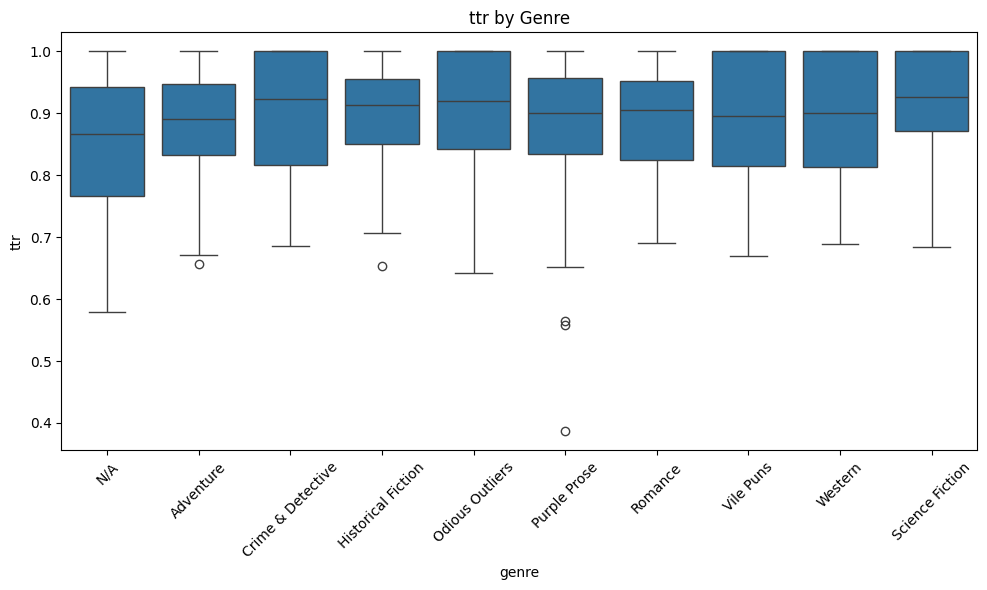

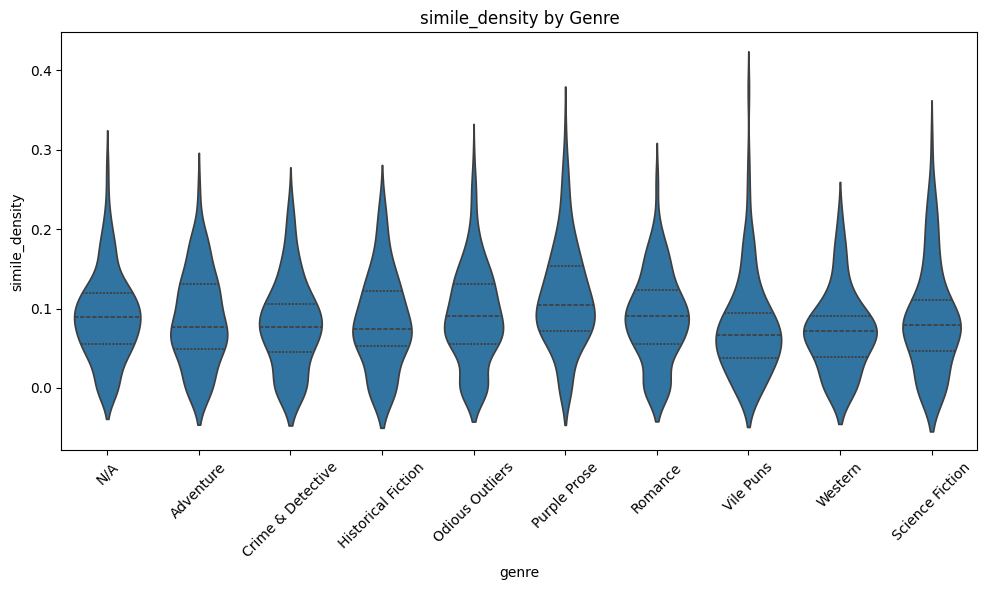

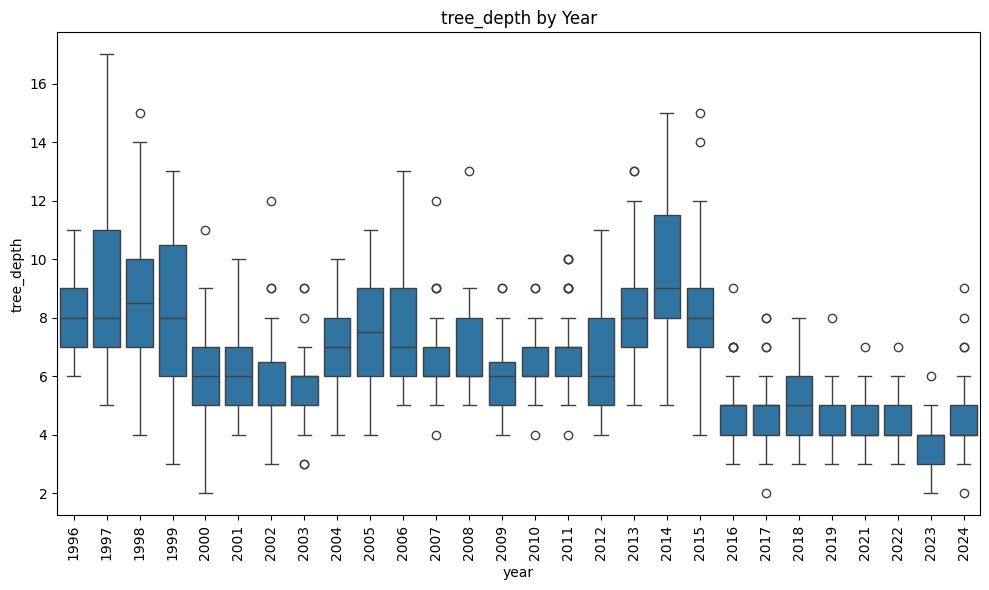

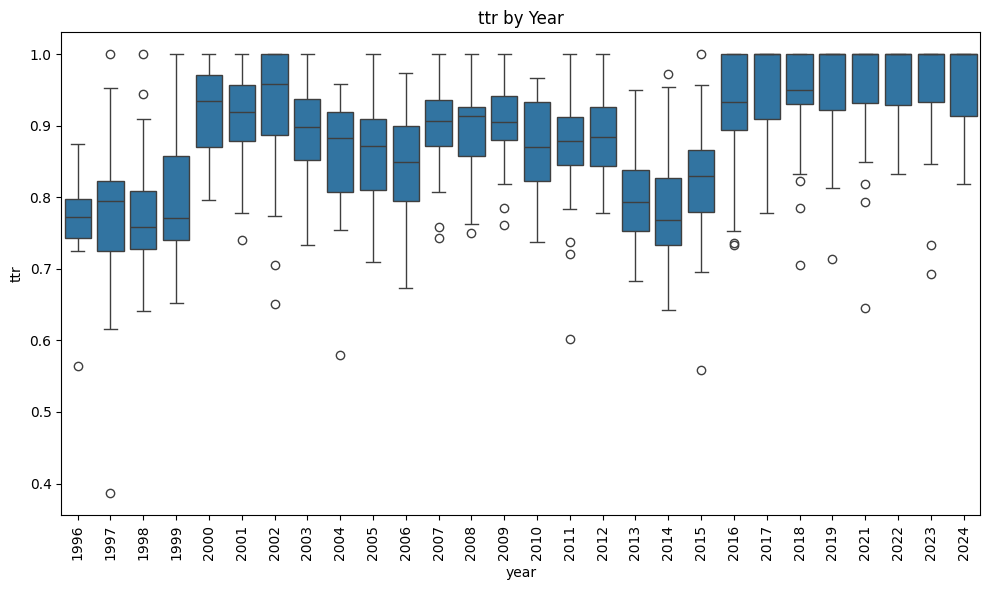

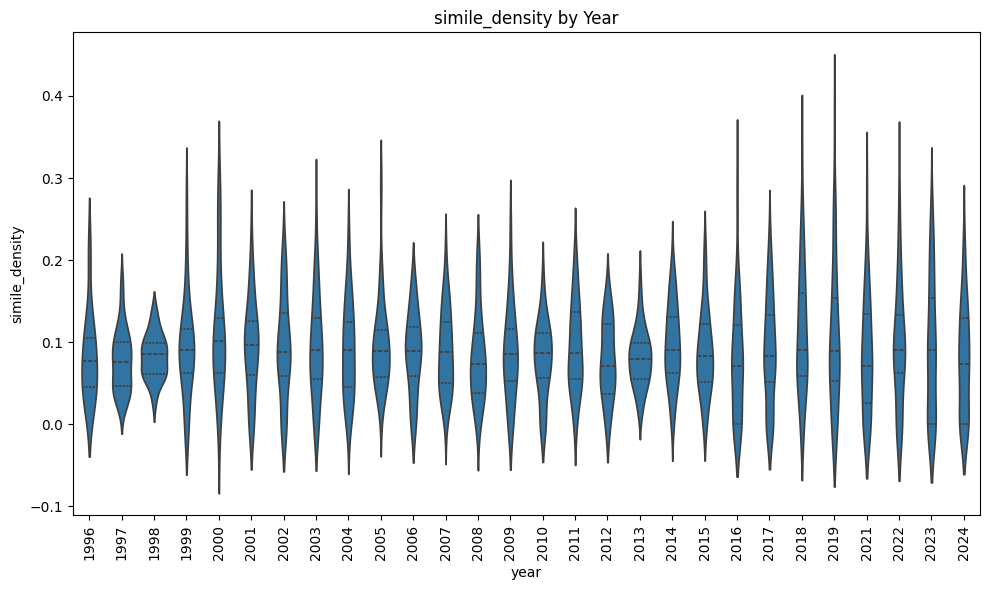

In [4]:
class BulwerLyttonAnalyzer:
    """Encapsulates all analysis logic in a reusable class"""

    def __init__(self, data_path: str | Path, *, gpu: bool = False):
        self.df: pd.DataFrame = self.load_data(data_path)
        self.nlp = self._init_nlp(gpu=gpu)
        self._simile_re = re.compile(r"\b(?:like|as)\b", flags=re.I)

    # 1. read
    def load_data(self, filepath: str) -> pd.DataFrame:
      # Load and clean TSV data
      df = pd.read_csv(filepath,
                       sep="\t",
                       quoting=csv.QUOTE_NONE,
                       on_bad_lines="skip",
                       keep_default_na=False
                       )
      expected = ["year", "text", "genre", "author", "location", "winning"]
      df.columns = expected[: len(df.columns)]
      df["genre"] = df["genre"].fillna("General")
      df["text"] = df["text"].astype(str)
      return df

    # 2. pipline
    def _init_nlp(self, *, gpu: bool = False) -> stanza.Pipeline:
      # Initialize Stanza
      return stanza.Pipeline(
            lang="en",
            processors="tokenize,pos,lemma,depparse,ner",
            use_gpu=gpu,
            tokenize_pretokenized=False,
            verbose=False,
            download_method=None
        )

    # 3. Feature
    # syntax
    @staticmethod
    def _tree_depth(sentence: stanza.models.common.doc.Sentence) -> int:
        """Return max depth from any node to ROOT (inclusive)."""
        # build parent dict once:
        parents = {word.id: word.head for word in sentence.words}
        max_depth = 0
        for wid in parents:
            d = 0
            while wid != 0:
                wid = parents[wid]
                d += 1
            max_depth = max(max_depth, d)
        return max_depth

    @staticmethod
    def _dependency_distance(sentence: stanza.models.common.doc.Sentence) -> float:
        """Mean absolute distance head<->dep."""
        dists = [abs(w.id - w.head) for w in sentence.words if w.head != 0]
        return sum(dists) / len(dists) if dists else 0.0

    _FEATURE_KEYS = [
        # syntactic
        "tree_depth", "dep_distance", "clause_ratio",
        "conj_count", "avg_sent_len",
        # lexical
        "ttr", "rare_ratio", "ner_density", "pos_diversity",
        # rhetoric
        "simile_density", "adj_count"
    ]

    def _zero_feat(self) -> Dict[str, float]:
        """dict with feature 0"""
        return {k: 0.0 for k in self._FEATURE_KEYS}

    def _extract_features(self, row: pd.Series) -> Dict[str, Any]:
        """Main feature extraction router"""
        text = str(row.get("text", "")).strip()
        if not text:
            return self._zero_feat()
        try:
            doc: stanza.Document = self.nlp(text)
        except Exception as e:
            logging.warning(
                "Stanza failed on row %s (%s) — %s",
                row.name, text[:40] + ("…" if len(text) > 40 else ""), e
            )
            return self._zero_feat()

        # Flatten tokens
        tokens = [w.text for s in doc.sentences for w in s.words]
        n_tokens = len(tokens)
        if n_tokens == 0:
            return self._zero_feat()

        feats = {}
        feats.update(self._extract_syntax_features(doc, n_tokens))
        feats.update(self._extract_lexical_features(doc, tokens))
        feats.update(self._extract_rhetoric_features(text, doc, n_tokens))
        return feats

    def _extract_syntax_features(self, doc: stanza.Document, n_tokens: int) -> Dict[str, float]:
        """Calculate syntactic complexity metrics"""
        if not doc.sentences:
            return {
                "tree_depth": 0.0,
                "dep_distance": 0.0,
                "clause_ratio": 0.0,
                "conj_count": 0.0,
                "avg_sent_len": 0.0
            }

        # Sentence-level metrics
        depths = []
        dep_dists = []
        sent_lengths = []
        n_clauses = 0
        n_conj = 0
        n_deprel = 0

        for sent in doc.sentences:
            depths.append(self._tree_depth(sent))
            dep_dists.append(self._dependency_distance(sent))
            sent_lengths.append(len(sent.words))

            for word in sent.words:
                if word.deprel in {"acl", "advcl", "relcl"}:
                    n_clauses += 1
                elif word.deprel == "conj":
                    n_conj += 1

            n_deprel += len(sent.words)

        return {
            "tree_depth": max(depths),
            "dep_distance": sum(dep_dists) / len(dep_dists),
            "clause_ratio": n_clauses / n_deprel if n_deprel else 0.0,
            "conj_count": n_conj,
            "avg_sent_len": sum(sent_lengths) / len(sent_lengths)
        }

    def _extract_lexical_features(self, doc: stanza.Document, tokens: List[str]) -> Dict[str, float]:
        """Calculate lexical creativity metrics"""
        if not tokens:
            return {
                "ttr": 0.0,
                "rare_ratio": 0.0,
                "ner_density": 0.0,
                "pos_diversity": 0.0
            }

        # Unique words
        unique_tokens = set(tokens)

        # Rare words (Zipf frequency < 3)
        rare_words = sum(1 for w in tokens if zipf_frequency(w, "en") < 3.0)

        # POS diversity
        pos_tags = [w.upos for s in doc.sentences for w in s.words]

        # NER density
        n_ents = len(doc.ents)

        return {
            "ttr": len(unique_tokens) / len(tokens),
            "rare_ratio": rare_words / len(tokens),
            "ner_density": n_ents / len(tokens),
            "pos_diversity": len(set(pos_tags)) / len(pos_tags) if pos_tags else 0.0
        }

    def _extract_rhetoric_features(self, text: str, doc: stanza.Document, n_tokens: int) -> Dict[str, float]:
        """Detect rhetorical devices"""
        if not doc.sentences:
            return {
                "simile_density": 0.0,
                "adj_count": 0.0
            }

        # Adjectives
        n_adj = sum(1 for w in doc.iter_words() if w.xpos and w.xpos.startswith("JJ"))

        # Similes
        n_like_as = len(self._simile_re.findall(text.lower()))

        return {
            "simile_density": (n_adj + n_like_as) / n_tokens if n_tokens else 0.0,
            "adj_count": n_adj
        }

    # 4. Analysis Methods
    # ----------------------------
    def analyze(self, sample_size: Optional[int] = None) -> None:
        """Run full analysis pipeline"""
        if sample_size is None:
          self.df = self.df.reset_index(drop=True)
        else:
          n = min(sample_size, len(self.df))
          self.df = (self.df.sample(n, random_state=42)
                         .reset_index(drop=True))

        # Apply feature extraction
        feature_dicts = self.df.apply(self._extract_features, axis=1).tolist()
        features_df   = pd.DataFrame(feature_dicts)

        dup_cols = [c for c in features_df.columns if c in self.df.columns]
        self.df.drop(columns=dup_cols, inplace=True, errors="ignore")
        self.df = pd.concat([self.df, features_df], axis=1)
        self.df = self.df.loc[:, ~self.df.columns.duplicated()].copy()

    def genre_summary(self) -> pd.DataFrame:
        """Statistical summary by genre"""
        num_cols = self.df.select_dtypes(include=['number']).columns
        return self.df.groupby("genre")[num_cols].agg(["mean", "std"])

    def plot_feature(
            self,
            feature: str,
            kind: str = "violin",
            by: str = "genre",
            order: Optional[List[str]] = None,
        ) -> None:
        """Visualize feature distribution by genre"""
        plt.figure(figsize=(10, 6))

        if by not in self.df.columns:
            raise ValueError(f"Column '{by}' not in DataFrame.")

        data = self.df.copy()
        if order is None and by == "year":
            order = sorted(data["year"].unique())

        if kind == "box":
            sns.boxplot(data=data, x=by, y=feature, order=order)
        elif kind == "swarm":
            sns.swarmplot(data=data, x=by, y=feature, order=order, size=3)
        else:
            sns.violinplot(data=data, x=by, y=feature, order=order, inner="quartile")

        plt.title(f"{feature} by {by.capitalize()}")
        plt.xticks(rotation=45 if by == "genre" else 90)
        plt.tight_layout()
        plt.show()

from google.colab import drive
drive.mount('/content/drive')

if __name__ == "__main__":

    !ls -R /content/drive/MyDrive | grep bulwer
    file_path = "/content/drive/MyDrive/bulwer.tsv"
    analyzer = BulwerLyttonAnalyzer("/content/drive/MyDrive/bulwer.tsv", gpu=True)
    analyzer.analyze()

    analyzer.df['genre'] = analyzer.df['genre'].str.strip().str.title()
    major_genres = analyzer.df['genre'].value_counts().head(10).index.tolist()
    analyzer.df = analyzer.df[analyzer.df['genre'].isin(major_genres)]

    from scipy.stats import kruskal
    groups = [g['tree_depth'].dropna() for _, g in analyzer.df.groupby('genre')]
    H, p = kruskal(*groups)
    print(f"Kruskal-Wallis H={H:.2f}, p={p:.3g}")

    # Show summary
    print(analyzer.genre_summary())

    # Visualize key features
    analyzer.plot_feature("tree_depth")
    analyzer.plot_feature("ttr", kind="box")
    analyzer.plot_feature("simile_density")
    analyzer.plot_feature("tree_depth", by="year", kind="box")
    analyzer.plot_feature("ttr", kind="box",  by="year")
    analyzer.plot_feature("simile_density", by="year")

In [5]:
!pip install -q scikit-posthocs

In [6]:
import scikit_posthocs as sp
p_matrix = sp.posthoc_dunn(analyzer.df, val_col='tree_depth', group_col='genre', p_adjust='fdr_bh')
print(p_matrix)

                    Adventure  Crime & Detective  Historical Fiction  \
Adventure            1.000000           0.205488            0.268742   
Crime & Detective    0.205488           1.000000            0.923570   
Historical Fiction   0.268742           0.923570            1.000000   
N/A                  0.079302           0.001647            0.002068   
Odious Outliers      0.078554           0.903485            0.866496   
Purple Prose         0.866496           0.079302            0.122833   
Romance              0.503041           0.030792            0.055057   
Science Fiction      0.337589           0.843774            0.866496   
Vile Puns            0.443212           0.671291            0.766382   
Western              0.443212           0.863105            0.866496   

                         N/A  Odious Outliers  Purple Prose   Romance  \
Adventure           0.079302         0.078554      0.866496  0.503041   
Crime & Detective   0.001647         0.903485      0.079302  